# RNN-LSTM Sınıflandırma ile Film Yorumlarında Duygu Analizi Yapma 




## Gerekli Kütüphanelerin Import Edilmesi

In [5]:
!pip install watermark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout2D, SpatialDropout1D, SpatialDropout3D
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
sns.set()
%load_ext watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
%watermark -a "Muhammet Demir" -u -d -v -m

Author: Muhammet Demir

Last updated: 2022-11-21

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## IMDB Film Yorumları Datasetini İndirme

In [7]:
imdb = pd.read_csv("IMDB Dataset.csv")
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Olumlu ve olumsuz cümle sayılarını öğrenme

In [8]:
imdb.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Örnek olarak datasetinin ilk cümlesinin nasıl kelimelere ayrıldığını görelim.

In [9]:
text = imdb['review'][0]
print(text)
print("<=================>")
print(word_tokenize(text))

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

# Veriyi hazır hale getirme

## Datasetindeki tüm cümleleri kelimelere ayıralım


In [10]:
cumleler = []
for text in imdb['review']:
    kelimeler = [word.lower() for word in word_tokenize(text)]
    cumleler.append(kelimeler)

## Toplam Cümle Sayısını Öğrenelim

In [11]:
cumle_sayisi = len(cumleler)
print(cumle_sayisi)

50000


## Her cümle için işleme girecek maksimum kelime kelime sayısını belirleyelim

In [12]:
max_uzunluk = 196

## Datasetini 'eğitim' ve 'test' olarak ayıralım

In [13]:
egitim_boyutu = int(imdb.shape[0] * 0.8)

egitim_verisi = imdb.review[:egitim_boyutu]
egitim_etiketi = imdb.sentiment[:egitim_boyutu]

test_verisi = imdb.review[egitim_boyutu:]
test_etiketi = imdb.sentiment[egitim_boyutu:]


## Tokenizer yardımı ile eğitim verisinin cümlelerini One Hot Code formatına dönüştürelim ve pad_sequences yardımı ile eşit boyutta(max_uzunluk) Numpy dizileri oluşturalım

In [14]:
tokenizer = Tokenizer(cumle_sayisi)
tokenizer.fit_on_texts(egitim_verisi)
egitim_verisi = tokenizer.texts_to_sequences(egitim_verisi)
egitim_verisi = pad_sequences(egitim_verisi, maxlen=max_uzunluk, truncating='post', padding='post')

## Örnek olarak verinin ilk indeksini ve indeks uzunluğunu görelim

In [15]:
egitim_verisi[0], len(egitim_verisi[0])

(array([   27,     4,     1,    80,  2102,    45,  1073,    12,   100,
          147,    39,   316,  2968,   409,   459,    26,  3173,    33,
           23,   200,    14,    11,     6,   614,    48,   606,    16,
           68,     7,     7,     1,    87,   148,    12,  3256,    68,
           41,  2968,    13,    92,  5626,     2, 16202,   134,     4,
          569,    60,   271,     8,   200,    36,     1,   673,   139,
         1712,    68,    11,     6,    21,     3,   118,    15,     1,
         7870,  2257,    38, 11540,    11,   118,  2495,    54,  5662,
           16,  5182,     5,  1438,   377,    38,   569,    92,     6,
         3730,     8,     1,   360,   353,     4,     1,   673,     7,
            7,     9,     6,   431,  2968,    14,    12,     6,     1,
        11736,   356,     5,     1, 14689,  6526,  2594,  1087,     9,
         2661,  1432,    20, 22583,   534,    32,  4795,  2451,     4,
            1,  1193,   117,    29,     1,  6893,    25,  2874, 12191,
      

## Bu sefer tokenizer yardımı ile test verisinin cümlelerini One Hot Code formatına dönüştürelim ve pad_sequences yardımı ile eşit boyutta(max_uzunluk) Numpy dizileri oluşturalım

In [16]:
test_verisi = tokenizer.texts_to_sequences(test_verisi)
test_verisi = pad_sequences(test_verisi, maxlen=max_uzunluk, truncating='post', padding='post')

## Örnek olarak verinin ilk indeksini ve indeks uzunluğunu görelim

In [17]:
test_verisi[0], len(test_verisi[0])

(array([   87,   122,    10,   180,     5,   132,    12,    10,  7131,
         3717,    20,     1,  1001,  2285,     2,    10,   255,     1,
           17,  2431,    10,  1311,     5,   103,     1,   222,  6349,
            4,     3,    19,    11,    17,   974,     3,   351,     5,
          215,  1011,   415,     9,    13,   215,  1380,    56,   235,
          402,   300,     4,   316,    23,   257,    19,   961,    12,
        22250,    12,    33,    66,    61,   212,    53,    16,    11,
          113,    13,   497,     2,     1,   102,    70,  5358,    15,
            1,    88,   172,     1,   473,   824,     8,     1,    64,
           67,    54,    49,  2406,    30,    29,    33,    90,    40,
        35787,    83,    46,   438,     4,     3,    74,   220,     2,
           10,   115,    21,    63,    12,    30,    29,   268,    10,
         1059,   137,    10,    78,    21,   119,    28,    13,     1,
           88,   175,     5,   728,  3423,   108,     8,     1,    17,
      

## Eğitim ve Test verisinin boyutlarını ve etiket boyutlarını görelim

In [18]:
print(egitim_verisi.shape, egitim_etiketi.shape)
print(test_verisi.shape, test_etiketi.shape)

(40000, 196) (40000,)
(10000, 196) (10000,)


## LabelEncoder yardımı ile etiketleri sayısal hale getirelim

In [19]:
le = LabelEncoder()
egitim_etiketi = le.fit_transform(egitim_etiketi)
test_etiketi = le.transform(test_etiketi)

# Modeli Oluşturma

## Input katmanı olarak Embedding'i seçtik. 4 LSTM ara katmanlı ve tek outputa sahip modelimizi oluşturduk.

In [20]:
model = Sequential()

model.add(
          Embedding(input_dim = cumle_sayisi, output_dim = 128,
                    input_length = max_uzunluk, trainable = True
        ))
model.add(
          LSTM(64, dropout = 0.1, return_sequences = True)  
        )
model.add(
          LSTM(64, dropout = 0.1, return_sequences = True)  
        )
model.add(
          LSTM(64, dropout = 0.1, return_sequences = True)  
        )
model.add(
          LSTM(32, dropout = 0.1)  
        )
model.add(
          Dense(1, activation = 'sigmoid')  
        )

## Modelin loss fonksiyonunu, optimizerını ve metricsini ayarladık

In [21]:
model.compile(loss ='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Modeli çalıştırmadan önce modelin özetini görelim

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 196, 128)          6400000   
                                                                 
 lstm (LSTM)                 (None, 196, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 196, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 196, 16)           3136      
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,465,769
Trainable params: 6,465,769
Non-

## Modeli çalıştıralım

In [23]:
sonuc = model.fit(egitim_verisi, egitim_etiketi, epochs = 10, batch_size = 32, validation_data = (test_verisi, test_etiketi))

Epoch 1/10
1250/1250 [==============================] - 55s 36ms/step - loss: 0.6818 - accuracy: 0.5622 - val_loss: 0.6772 - val_accuracy: 0.5773
Epoch 2/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.6794 - accuracy: 0.5727 - val_loss: 0.6777 - val_accuracy: 0.5778
Epoch 3/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.6775 - accuracy: 0.5764 - val_loss: 0.6708 - val_accuracy: 0.5869
Epoch 4/10
1250/1250 [==============================] - 43s 35ms/step - loss: 0.6928 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4993
Epoch 5/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6929 - val_accuracy: 0.4993
Epoch 6/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.6697 - accuracy: 0.5688 - val_loss: 0.6062 - val_accuracy: 0.7129
Epoch 7/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.5107 - accuracy: 0.7635 - val_loss: 0.4685 -

## Modelin training ve validation loss kısmını grafik üzerinde görelim

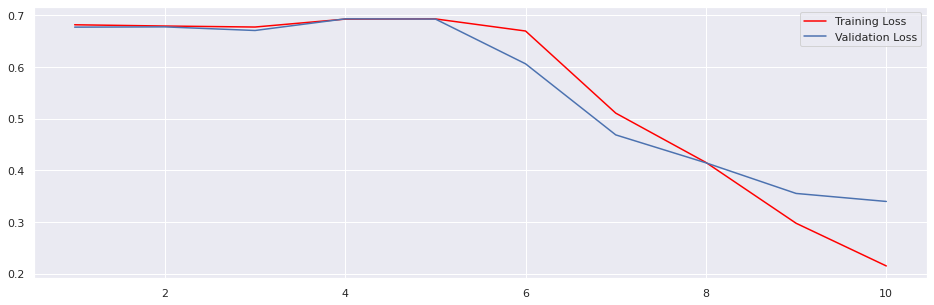

In [24]:
plt.figure(figsize = (16,5))
epochs = range(1, len(sonuc.history['accuracy'])+1)
plt.plot(epochs, sonuc.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, sonuc.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

# Örnekler üzerinde model performansını inceleme

In [25]:
ornek_cumle = ['This movie was not good at all. It had some good parts like the acting was pretty good but the was not impressing at all.']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

This movie was not good at all. It had some good parts like the acting was pretty good but the was not impressing at all.
1/1 [==============================] - 1s 1s/step
Cumlenin Olumluluk Orani : [0.51410556]


In [28]:
ornek_cumle = ['I love that movie.']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

I love that movie.
1/1 [==============================] - 0s 31ms/step
Cumlenin Olumluluk Orani : [0.97433794]


In [29]:
ornek_cumle = ['This movie is worst']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

This movie is worst
1/1 [==============================] - 0s 34ms/step
Cumlenin Olumluluk Orani : [0.16893849]


In [32]:
ornek_cumle = ['One of the best films of all time, an absolute masterpiece. The Godfather is arguably the best gangster drama as well as setting the standard for cinema.']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

One of the best films of all time, an absolute masterpiece. The Godfather is arguably the best gangster drama as well as setting the standard for cinema.
1/1 [==============================] - 0s 54ms/step
Cumlenin Olumluluk Orani : [0.97837055]


In [33]:
ornek_cumle = ['Now I know this movie is the national pride of America, but I can not help it, it is a blown up, too long, stupid movie. Now you can say oh heis sixteen, he does know anything about movies, well you are wrong!']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

Now I know this movie is the national pride of America, but I can not help it, it is a blown up, too long, stupid movie. Now you can say oh heis sixteen, he does know anything about movies, well you are wrong!
1/1 [==============================] - 0s 48ms/step
Cumlenin Olumluluk Orani : [0.39750227]


In [34]:
ornek_cumle = ['And yet so many low rates among the commentators despite excellent direction, script and dialogue and very good acting. Too bad for those many sad and depressed people with very poor sense of humor.']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

And yet so many low rates among the commentators despite excellent direction, script and dialogue and very good acting. Too bad for those many sad and depressed people with very poor sense of humor.
1/1 [==============================] - 0s 49ms/step
Cumlenin Olumluluk Orani : [0.63178694]


In [35]:
ornek_cumle = ['Couldnt watch more than 45mins of it. Waste of money. Horrible dialogue. Worthless action sequences. Big misses lately with director producer. He also produced Kate, which stunk too.']
ornek_cumle_tokened = tokenizer.texts_to_sequences(ornek_cumle)
ornek_cumle_padded = pad_sequences(ornek_cumle_tokened, maxlen=max_uzunluk, truncating='post', padding='post')
print(ornek_cumle[0])
print("Cumlenin Olumluluk Orani : {}".format(model.predict(ornek_cumle_padded)[0]))

Couldnt watch more than 45mins of it. Waste of money. Horrible dialogue. Worthless action sequences. Big misses lately with director producer. He also produced Kate, which stunk too.
1/1 [==============================] - 0s 77ms/step
Cumlenin Olumluluk Orani : [0.01770992]
